### Scraping www.congress.gov with BeautifulSoup
First, I needed to scrape https://www.congress.gov/legislation to get the links for each bill. Each page has 25 bills on it, among other things. The URL ending of ```?q=%7B"bill-status"%3A"law"%7D``` filters the results to only be enacted bills (bills that became law). By looking at a few of the pages, I noticed that the hyperlinks I need are essentially in the same place on every page (inside ```<h2>``` within an ```<ol>``` tag of class ```results_list```).

So I can scrape all the hyperlinks with a nested loop. The outer loop grabs the data in the table on each page, and the inner loop extracts the hyperlinks for bills. Out of respect for www.congress.gov's servers, I store the links in a list and write the list to a text file so I don't have to scrape them again.

In [36]:
from __future__ import division
import re
import nltk
from nltk.corpus import stopwords
import bs4
import urllib2
import time
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

In [2]:
# Get the hyperlinks for all of the bills
base_law_url = 'https://www.congress.gov/legislation?q=%7B"bill-status"%3A"law"%7D&page='
relevant_links = []
data_path = '/users/nickbecker/Python_Projects/clustering_laws/'

for i in xrange(1, 150):
    print 'Page {0}'.format(i)
    
    response = urllib2.urlopen(base_law_url + str(i))
    html = response.read()
    soup = bs4.BeautifulSoup(html)
    tags = soup.find('ol', {'class' : 'results_list'})
    h2_list = tags.find_all('h2')
    
    for j in xrange(0, len(h2_list)):
        #print j
        href = h2_list[j].find('a').decode().encode('utf-8')
        
        m = re.search('href="(.+)">', href)
        if m:
            relevant_links.append(m.group(1))

with open(data_path + 'law_links.txt', 'w') as handle:
    for link in relevant_links:
        handle.write("%s\n" % link)

Page 1


KeyboardInterrupt: 

With the hyperlinks to few thousand enacted bills in relevant_links, I next need to download the actual bills. By looking at a few of the pages, I noticed that access to the text version of the bills (instead of the PDF) is controlled by the URL ending ```/text?format=txt```. On each page, the text stored in a ```<pre>``` tag with id ```billTextContainer```.

By looping through ```relevant_links```, I grab the title and text of each bill and store them in ```titles_list``` and ```bills_text_list```. I'll zip them into a the dictionary ```bills_dictionary``` with the titles as keys and text as values.

In [ ]:
# Get the text and titles of the bills
titles_list = []
bills_text_list = []
text_ending = '/text?format=txt'

html_tags_re = re.compile(r'<[^>]+>')
def remove_html_tags(text):
    return html_tags_re.sub('', text)

for i in xrange(len(relevant_links)):
    print i
    response = urllib2.urlopen(relevant_links[i] + text_ending)
    html = response.read()
    soup = bs4.BeautifulSoup(html)
    
    # text
    text_tags = soup.find('pre', {'id' : 'billTextContainer'})
    
    if text_tags:
        text = text_tags.decode().encode('utf-8')
        text = remove_html_tags(text)
        bills_text_list.append(text)
        
        # titles
        title_soup = soup.find('h1', {'class' : 'legDetail'})
        title_soup = title_soup.decode().encode('utf-8')
        st = title_soup.find('">') + len('">')
        end = title_soup.find('<span>')
        
        titles_list.append(title_soup[st:end])

bills_dictionary = dict(zip(titles_list, bills_text_list))

with open(data_path + 'bills_dictionary.pickle', 'wb') as handle:
    pickle.dump(bills_clean_dictionary, handle)

### Cleaning the bills
Let's take a look at the text of one of the bills:

In [2]:
with open(data_path + 'bills_dictionary.pickle', 'r') as handle:
    bills_dictionary = pickle.load(handle)

In [50]:
print bills_dictionary['H.R.1000 - William Howard Taft National Historic Site Boundary Adjustment Act of 2001']


[107th Congress Public Law 60]
[From the U.S. Government Printing Office]


&amp;lt;DOC&amp;gt;
[DOCID: f:publ060.107]


[[Page 115 STAT. 408]]

Public Law 107-60
107th Congress

                                 An Act


 
To adjust the boundary of the William Howard Taft National Historic Site 
  in the State of Ohio, to authorize an exchange of land in connection 
    with the historic site, and for other purposes. &amp;lt;&amp;lt;NOTE: Nov. 5, 
                         2001 -  [H.R. 1000]&amp;gt;&amp;gt; 

    Be it enacted by the Senate and House of Representatives of the 
United States of America in Congress &amp;lt;&amp;lt;NOTE: William Howard Taft 
National Historic Site Boundary Adjustment Act of 2001. 16 USC 461 
note.&amp;gt;&amp;gt; assembled,

SECTION 1. SHORT TITLE.

    This Act may be cited as the ``William Howard Taft National Historic 
Site Boundary Adjustment Act of 2001''.

SEC. 2. EXCHANGE OF LANDS AND BOUNDARY ADJUSTMENT, WILLIAM HOWARD TAFT 
            NATIONAL 

Nice! This looks pretty good for a raw file. Since we're going to use tf-idf, we need to clean the text to keep only letters. We'll also remove stopwords (using the standard lists  included in NLTK and sklearn) to remove words that provide very little information.

After cleaning, I zip the titles and clean text into a new dictionary ```bills_clean_dictionary``` and save it for quick recall.

In [ ]:
def clean_bill(raw_bill):
    """
    Function to clean bill text to keep only letters and remove stopwords
    Returns a string of the cleaned bill text
    """
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_bill)
    words = letters_only.lower().split()
    stopwords_eng = set(stopwords.words("english"))
    useful_words = [x for x in words if not x in stopwords_eng]
    
    # Combine words into a paragraph again
    useful_words_string = ' '.join(useful_words)
    return(useful_words_string)

bills_text_list_clean = map(clean_bill, bills_text_list)
bills_clean_dictionary = dict(zip(titles_list, bills_text_list_clean))

with open(data_path + 'bills_dictionary_clean.pickle', 'wb') as handle:
    pickle.dump(bills_clean_dictionary, handle)

Let's see how the cleaned law looks:

In [6]:
with open(data_path + 'bills_dictionary_clean.pickle', 'r') as handle:
    clean_bills_dictionary = pickle.load(handle)

In [7]:
print clean_bills_dictionary['H.R.1000 - William Howard Taft National Historic Site Boundary Adjustment Act of 2001']

th congress public law u government printing office amp lt doc amp gt docid f publ page stat public law th congress act adjust boundary william howard taft national historic site state ohio authorize exchange land connection historic site purposes amp lt amp lt note nov h r amp gt amp gt enacted senate house representatives united states america congress amp lt amp lt note william howard taft national historic site boundary adjustment act usc note amp gt amp gt assembled section short title act may cited william howard taft national historic site boundary adjustment act sec exchange lands boundary adjustment william howard taft national historic site ohio definitions section historic site term historic site means william howard taft national historic site cincinnati ohio established pursuant public law stat u c note map term map means map entitled proposed boundary map william howard taft national historic site hamilton county cincinnati ohio numbered dated november secretary term secr

Perfect! Way harder to read, but way more useful for finding textual similarities

### Calculating TF-IDF Vectors

So we've got a dictionary of laws and their text. Now it's time to calculate the tf-idf vectors. We'll initialize a stemmer from NLTK to treat words like ```incredible``` and ```incredibly``` as the same token. Then we'll initialize a TfidfVectorizer from ```sklearn``` and fit our corpus to the vectorizer. Since our corpus is all the values of the dictionary ```clean_bills_dictionary```, we'll pass ```clean_bills_dictionary.values()``` to the vectorizer.

In [4]:
with open('/users/nickbecker/Python_Projects/bills_dictionary_clean.pickle', 'r') as handle:
    clean_bills_dictionary = pickle.load(handle)

stemmer = PorterStemmer()

def stem_words(words_list, stemmer):
    return [stemmer.stem(word) for word in words_list]

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_words(tokens, stemmer)
    return stems

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(clean_bills_dictionary.values())

So what do we actually have now? ```tfs``` should be a matrix, where each row represents a law and each column represents a token (word) in the corpus. Let's see if we're right.

In [5]:
tfs

<3725x30894 sparse matrix of type '<type 'numpy.float64'>'
	with 1125934 stored elements in Compressed Sparse Row format>

Perfect. It's a sparse numpy array because it's essentially a matrix of zeros, with a handful of nonzero elements per row. The sparse matrix format is more efficient storage wise. Let's save the sparse matrix so we won't have to recalculate it. These functions (from the Scipy user group) let us easily save and load the array.

In [5]:
from scipy.sparse import csr_matrix

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [ ]:
save_sparse_csr(data_path + 'laws_tf_idf.npz', tfs)

### Finding a Law's Nearest Neighbors with Cosine Distance

Finally, we can find similar laws! We'll initialize a NearestNeighbors class and fit our tf-idf matrix to it. Since we want to use cosine distance as our distance metric, I'll initialize it with ```metric='cosine'```.

In [11]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf.fit(tfs)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

Let's define a function to print the k nearest neighbors for any query law. Since we have our corpus stored as a dictionary, we'll define the function to take the dictionary as an input.

In [12]:
def print_nearest_neighbors(query_tf_idf, full_bill_dictionary, knn_model, k):
    """
    Inputs: a query tf_idf vector, the dictionary of bills, the knn model, and the number of neighbors
    Prints the k nearest neighbors
    """
    distances, indices = knn_model.kneighbors(query_tf_idf, n_neighbors = k+1)
    nearest_neighbors = [full_bill_dictionary.keys()[x] for x in indices.flatten()]
    
    for bill in xrange(len(nearest_neighbors)):
        if bill == 0:
            print 'Query Law: {0}\n'.format(nearest_neighbors[bill])
        else:
            print '{0}: {1}\n'.format(bill, nearest_neighbors[bill])

Time to test it! I'll pick a couple random laws and find their nearest neighbors.

In [18]:
bill_id = np.random.choice(tfs.shape[0])
print_nearest_neighbors(tfs[bill_id], clean_bills_dictionary, model_tf_idf, k=5)

Query Law: H.R.2517 - Protecting Our Children Comes First Act of 2007

1: H.R.3209 - Recovering Missing Children Act

2: S.1738 - PROTECT Our Children Act of 2008

3: S.249 - Missing, Exploited, and Runaway Children Protection Act

4: H.R.3092 - E. Clay Shaw, Jr. Missing Children's Assistance Reauthorization Act of 2013

5: S.151 - PROTECT Act



In [19]:
bill_id = np.random.choice(tfs.shape[0])
print_nearest_neighbors(tfs[bill_id], clean_bills_dictionary, model_tf_idf, k=5)

Query Law: H.R.539 - Caribbean National Forest Act of 2005

1: S.4001 - New England Wilderness Act of 2006

2: H.R.4750 - Big Sur Wilderness and Conservation Act of 2002 

3: H.R.233 - Northern California Coastal Wild Heritage Wilderness Act

4: S.503 - Spanish Peaks Wilderness Act of 2000

5: H.R.15 - Otay Mountain Wilderness Act of 1999



Pretty good! Remember, we didn't use the title of the laws in the analysis. These rankings are just based on the textual similarity. Since the nearest neighbors seem to be decent, let's try some k-means clustering.

## Clustering with K-Means
With the groundwork already in place, all we have to do is implement the k-means model. Ideally, we'd choose the number of clusters based on domain knowledge. We could also use one of a variety of techniques to find a "good" number of clusters such as using the Gap Statistic or the Elbow Method. For simplicity, I'll just set `k = 50`. If the data were evenly distributed across clusters, each cluster would have 2% of the data, which seems fine to me for this blog post.

In [10]:
tfs = load_sparse_csr(data_path + 'laws_tf_idf.npz')

To implement k-means, we initialize the `KMeans` class from `sklearn.cluster` as `km` and fit our tf-idf matrix `tfs` to the KMeans instance.

In [11]:
from sklearn.cluster import KMeans

k = 50
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5,
                verbose=1)
km.fit(tfs)

Initialization complete
Iteration  0, inertia 4627.378
Iteration  1, inertia 2772.718
Iteration  2, inertia 2740.741
Iteration  3, inertia 2727.465
Iteration  4, inertia 2719.431
Iteration  5, inertia 2712.857
Iteration  6, inertia 2707.826
Iteration  7, inertia 2704.319
Iteration  8, inertia 2702.306
Iteration  9, inertia 2700.195
Iteration 10, inertia 2698.325
Iteration 11, inertia 2696.734
Iteration 12, inertia 2696.002
Iteration 13, inertia 2695.693
Iteration 14, inertia 2695.298
Iteration 15, inertia 2695.016
Iteration 16, inertia 2694.730
Iteration 17, inertia 2694.279
Iteration 18, inertia 2693.847
Iteration 19, inertia 2693.421
Iteration 20, inertia 2692.685
Iteration 21, inertia 2691.712
Iteration 22, inertia 2690.647
Iteration 23, inertia 2690.048
Iteration 24, inertia 2689.891
Iteration 25, inertia 2689.750
Iteration 26, inertia 2689.693
Iteration 27, inertia 2689.634
Iteration 28, inertia 2689.605
Iteration 29, inertia 2689.587
Iteration 30, inertia 2689.578
Iteration 31, i

KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=50, n_init=5,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=1)

Let's look at the cluster assignments. What's the distribution of cluster assignments?

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

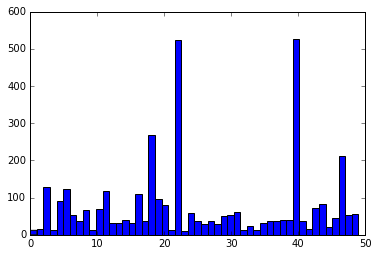

In [26]:
plt.hist(km.labels_, bins=k)
plt.show()

So it's not uniformly distributed (which makes sense), but it's not a complete trainwreck. Good enough to push forward. Let's take assign the bills to their clusters and see if they make sense. We'll create a dictionary with the clusters as keys and the laws assigned to their respective clusters as values.

In [34]:
with open(data_path + 'bills_dictionary_clean.pickle', 'r') as handle:
    clean_bills_dictionary = pickle.load(handle)

In [35]:
cluster_assignments_dict = {}

for i in set(km.labels_):
    #print i
    current_cluster_bills = [clean_bills_dictionary.keys()[x] for x in np.where(km.labels_ == i)[0]]
    cluster_assignments_dict[i] = current_cluster_bills

Let's take a look at a couple random clusters.

In [147]:
cluster_pick = np.random.choice(len(set(km.labels_)))
print 'Cluster {0}'.format(cluster_pick)
cluster_assignments_dict[cluster_pick]

Cluster 41


['H.R.2719 - Transportation Security Acquisition Reform Act',
 'H.R.1626 - DHS IT Duplication Reduction Act of 2015',
 'H.R.1801 - Risk-Based Security Screening for Members of the Armed Forces Act',
 'S.2516 - Kendell Frederick Citizenship Assistance Act',
 'H.R.3068 - Federal Protective Service Guard Contracting Reform Act of 2008',
 'H.R.3978 - First Responder Anti-Terrorism Training Resources Act',
 'H.R.3801 - Ultralight Aircraft Smuggling Prevention Act of 2012',
 'S.3542 - No-Hassle Flying Act of 2012',
 'S.1638 - Department of Homeland Security Headquarters Consolidation Accountability Act of 2015',
 'H.R.3210 - Pay Our Military Act',
 'H.R.915 - Jaime Zapata Border Enforcement Security Task Force Act',
 'H.R.2952 - Cybersecurity Workforce Assessment Act',
 'H.R.4954 - SAFE Port Act',
 'H.R.615 - DHS Interoperable Communications Act',
 'H.R.553 - Reducing Over-Classification Act',
 'S.1447 - Aviation and Transportation Security Act',
 'S.2519 - National Cybersecurity Protection 

Okay, so cluster 41 seems to have mostly laws about US security. Let's pick another random cluster

In [146]:
cluster_pick = np.random.choice(len(set(km.labels_)))
print 'Cluster {0}'.format(cluster_pick)
cluster_assignments_dict[cluster_pick]

Cluster 27


['S.3397 - Secure and Responsible Drug Disposal Act of 2010',
 'H.R.1321 - Microbead-Free Waters Act of 2015',
 'S.3560 - QI Program Supplemental Funding Act of 2008',
 'H.R.1132 - National All Schedules Prescription Electronic Reporting Act of 2005',
 'H.R.2751 - FDA Food Safety Modernization Act',
 'H.R.4679 - Antimicrobial Regulation Technical Corrections Act of 1998',
 'S.313 - Animal Drug User Fee Act of 2003',
 'H.R.3204 - Drug Quality and Security Act',
 'H.R.5651 - Medical Device User Fee and Modernization Act of 2002',
 'S.3187 - Food and Drug Administration Safety and Innovation Act',
 'S.3546 - Dietary Supplement and Nonprescription Drug Consumer Protection Act',
 'S.650 - Pediatric Research Equity Act of 2003',
 'H.R.3633 - Controlled Substances Trafficking Prohibition Act',
 'H.R.4771 - Designer Anabolic Steroid Control Act of 2014',
 'S.1395 - Controlled Substances Export Reform Act of 2005',
 'S.524 - Comprehensive Addiction and Recovery Act of 2016',
 'H.R.1256 - Family

Cluster 27 looks pretty tight also - lots of bills about food, drugs, and medicine. Nice! We've got some decent clusters, and we try to figure out the themes by looking at the titles of the laws. But can we do better than just looking at the titles?

## Determining Cluster Themes with TF-IDF
What if we reverse engineered the cluster "themes" from the text of the laws by employing tf-idf again? Within any single cluster, we have a set of laws. If we calculate the inverse document frequencies for all of the words in the cluster's corpus, we'll know which words should provide the least weight. Essentially, the lowest idf-weight words should correspond to the general themes present in most of the documents.

Since so many laws have `United States` in them, we'll add those words to the set of stopwords. Then we can just clean each cluster's laws again, estimate the idf vectors for the cluster, and see if the lowest weighted terms show any general themes. Since apparently I can't stop using dictionaries, we'll store the bottom 5 words in the dictionary `cluster_thems_dict`.

In [148]:
stemmer = PorterStemmer()

def stem_words(words_list, stemmer):
    return [stemmer.stem(word) for word in words_list]

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_words(tokens, stemmer)
    return stems

def clean_bill(raw_bill):
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_bill)
    words = letters_only.lower().split()
    stopwords_eng = set(stopwords.words("english"))
    stopwords_updated = stopwords_eng.add(u'united')
    stopwords_updated = stopwords_eng.add(u'states')
    useful_words = [x for x in words if not x in stopwords_eng]
    
    # Combine words into a paragraph again
    useful_words_string = ' '.join(useful_words)
    return(useful_words_string)

In [165]:
cluster_themes_dict = {}

for key in cluster_assignments_dict.keys():
    current_tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
    current_tfidf = TfidfVectorizer(stop_words='english')
    current_tfs = current_tfidf.fit_transform(map(clean_bill, cluster_assignments_dict[key]))
    
    current_tf_idfs = dict(zip(current_tfidf.get_feature_names(), current_tfidf.idf_))
    tf_idfs_tuples = current_tf_idfs.items()
    cluster_themes_dict[key] = sorted(tf_idfs_tuples, key = lambda x: x[1])[:5]    

Sweet. Let's look at clusters 27 and 41 again.

In [166]:
print 'Cluster 27 key words: {0}'.format([x[0] for x in cluster_themes_dict[27]])
print 'Cluster 41 key words: {0}'.format([x[0] for x in cluster_themes_dict[41]])

Cluster 27 key words: [u'act', u'drug', u'fee', u'user', u'food']
Cluster 41 key words: [u'act', u'security', u'border', u'homeland', u'reform']


Those looks great! The laws in cluster 27 are generally about food and drugs, and the ones in cluster 41 are about security. The laws in these clusters appear linearly separable in this 30894-dimensional space. Looks like using inverse document frequency to recover cluster themes might be pretty effective. But do we really believe we can create 50 well separated clusters in this space?

### Visualizing the Laws as TF-IDF Vectors using t-SNE
How can we "squeeze" the information contained in the high dimensional space down to an array in R<sup>2</sup>, which we can visualize easily with a scatter plot. One way is Principal Components Analysis. Another way is t-SNE, or t-distributed Stochastic Neighbor Embedding. t-SNE is an extension of SNE. So what is SNE?

In their [t-SNE paper](http://www.cs.toronto.edu/~hinton/absps/tsne.pdf), van der Maaten and Hinton describe the core of stochastic neighbor embedding as:

1) "estimating the similarity of datapoint x<sub>j</sub> to datapoint x<sub>i</sub> is the conditional probability, p<sub>j|i</sub>, that x<sub>i</sub> would pick x<sub>j</sub> as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at x<sub>i</sub>."

2) "For the low-dimensional counterparts y<sub>i</sub> and y<sub>j</sub> of the high-dimensional datapoints x<sub>i</sub> and x<sub>j</sub>, it is possible to compute a similar conditional probability, which we denote by q<sub>j|i</sub>."

3) "Find a low-dimensional data representation that minimizes the mismatch between p<sub>j|i</sub> and q<sub>j|i</sub>."

So we're essentially minimizing a cost function with gradient descent to find a low dimensional data representation that keeps "close" points together in the new dimensions. Cool. Let's do it.

First we'll decompose our tf-idf matrix `tfs` into a lower dimensional space since most our space is sparse.

In [172]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [170]:
k = 50
tfs_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(tfs)

Let's take a look at the first law's representation in both spaces.

In [184]:
print tfs[0].A
print '\n'
print tfs_reduced[0]

[[ 0.  0.  0. ...,  0.  0.  0.]]


[  4.38423875e-01  -3.00248418e-03   2.33335259e-01  -1.37438286e-01
   2.84206786e-01   2.66262552e-01  -2.12074337e-02   4.12346062e-02
   7.49885919e-02   6.55497460e-02  -9.97137039e-03  -5.88120140e-02
   2.51327455e-02   4.93963103e-02  -1.73767695e-01   3.58991616e-02
  -5.78711078e-02  -1.38381766e-02   9.32298684e-05   1.16180873e-01
   1.92899842e-02   8.03687428e-02  -8.54831822e-02  -6.23085873e-02
   3.07540318e-03  -3.27680837e-02  -7.40418560e-02  -1.64382083e-02
  -6.36221396e-02  -1.26110346e-01   5.17822091e-02  -7.73297134e-03
  -1.19039336e-01  -2.34091646e-02  -5.07190226e-02  -2.28139221e-02
   5.15173022e-02  -7.54591685e-03   4.34970059e-02   1.01454832e-01
  -5.86684190e-02  -5.62348273e-02  -1.63426764e-02   2.02803569e-02
  -1.08796287e-01  -1.11800341e-01   4.79279500e-02  -5.37942841e-02
  -3.69779039e-02   1.05691593e-01]


Next, we'll find a 2-D representation of our 50-dimensional tensor using t-SNE.

In [171]:
tfs_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(tfs_reduced)
print tfs_embedded.shape

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3725
[t-SNE] Computed conditional probabilities for sample 2000 / 3725
[t-SNE] Computed conditional probabilities for sample 3000 / 3725
[t-SNE] Computed conditional probabilities for sample 3725 / 3725
[t-SNE] Mean sigma: 0.092009
[t-SNE] Iteration 25: error = 1.7617760, gradient norm = 0.0080711
[t-SNE] Iteration 50: error = 1.6578789, gradient norm = 0.0055832
[t-SNE] Iteration 75: error = 1.3032191, gradient norm = 0.0022066
[t-SNE] Iteration 100: error = 1.2346758, gradient norm = 0.0018688
[t-SNE] Error after 100 iterations with early exaggeration: 1.234676
[t-SNE] Iteration 125: error = 1.1260014, gradient norm = 0.0014051
[t-SNE] Iteration 150: error = 1.0931615, gradient norm = 0.0012835
[t-SNE] Iteration 175: error = 1.0850121, gradient norm = 0.0012593
[t-SNE] Iteration 200: error = 1.0827918, gradient norm = 0.0012533
[t-SNE] Iterat

With our vector embeddings in hand, let's plot the laws colored according to their k-means cluster assignment.

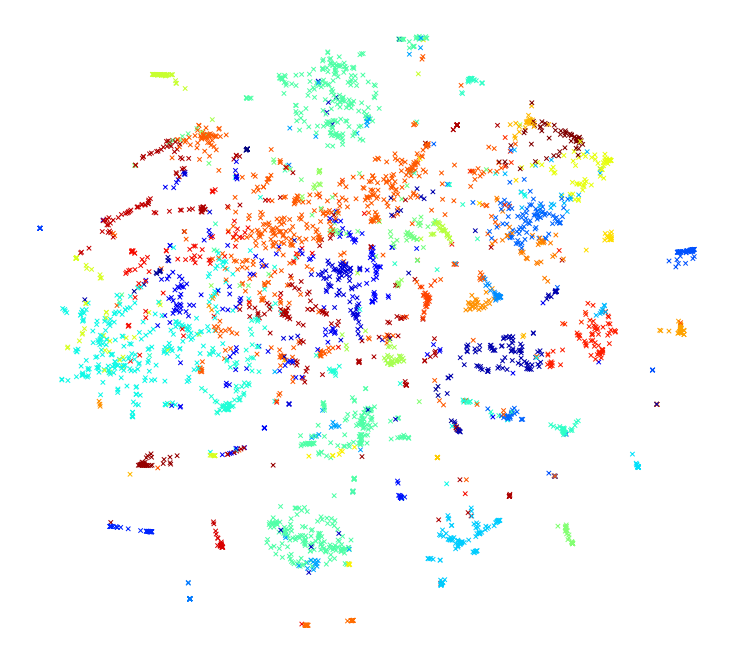

In [167]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker="x", c = km.labels_)
plt.show()

Not too bad! We can see some clusters are mostly on their own, while some are intermingled with other clusters. Considering we picked `k = 50` arbitrarily, I'd say this is a pretty good result.

## Data Repository
I was pretty surprised this textual data wasn't easily accessible, so I put it in a Github repository. You can find it on my [Github page](https://github.com/beckernick).